In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
%matplotlib inline

In [2]:
df = pd.read_csv('C:/workfiles/denver-crime-data/crime.csv')

In [3]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

In [4]:
df1 = df.drop(['INCIDENT_ID', 'OFFENSE_ID', 'OFFENSE_CODE', 'OFFENSE_CODE_EXTENSION', 'INCIDENT_ADDRESS', 
               'IS_CRIME', 'IS_TRAFFIC','LAST_OCCURRENCE_DATE','NEIGHBORHOOD_ID','OFFENSE_TYPE_ID', 'GEO_X', 'GEO_Y', 
               'REPORTED_DATE', 'FIRST_OCCURRENCE_DATE'], axis= 1)
df1.head()

,OFFENSE_CATEGORY_ID,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID
0,all-other-crimes,-104.809881,39.773188,5,521
1,larceny,-104.781434,39.785649,5,522
2,theft-from-motor-vehicle,-104.957381,39.663490,3,314
3,larceny,-104.941440,39.702698,3,312
4,larceny,-104.955370,39.717107,3,311


In [5]:
df1 = df1.dropna(axis=0, how='any')
df1.count()

OFFENSE_CATEGORY_ID    484260
GEO_LON                484260
GEO_LAT                484260
DISTRICT_ID            484260
PRECINCT_ID            484260
dtype: int64

In [6]:
df1 = df1[df.OFFENSE_CATEGORY_ID != 'all-other-crimes']
df1.count()

c:\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


OFFENSE_CATEGORY_ID    395160
GEO_LON                395160
GEO_LAT                395160
DISTRICT_ID            395160
PRECINCT_ID            395160
dtype: int64

In [7]:
df1 = df1[df.OFFENSE_CATEGORY_ID != 'traffic-accident']
df1.count()

c:\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


OFFENSE_CATEGORY_ID    268034
GEO_LON                268034
GEO_LAT                268034
DISTRICT_ID            268034
PRECINCT_ID            268034
dtype: int64

In [8]:
df1 = df1[df.OFFENSE_CATEGORY_ID != 'sexual-assault']
df1.count()

c:\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


OFFENSE_CATEGORY_ID    268033
GEO_LON                268033
GEO_LAT                268033
DISTRICT_ID            268033
PRECINCT_ID            268033
dtype: int64

In [9]:
df1 = df1[df.OFFENSE_CATEGORY_ID != 'public-disorder']
df1.count()

c:\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


OFFENSE_CATEGORY_ID    217094
GEO_LON                217094
GEO_LAT                217094
DISTRICT_ID            217094
PRECINCT_ID            217094
dtype: int64

In [10]:
df1 = df1[df.OFFENSE_CATEGORY_ID != 'larceny']
df1.count()

c:\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


OFFENSE_CATEGORY_ID    167920
GEO_LON                167920
GEO_LAT                167920
DISTRICT_ID            167920
PRECINCT_ID            167920
dtype: int64

In [11]:
df1 = df1[df1.OFFENSE_CATEGORY_ID != 'other-crimes-against-persons']
df1.count()

OFFENSE_CATEGORY_ID    143982
GEO_LON                143982
GEO_LAT                143982
DISTRICT_ID            143982
PRECINCT_ID            143982
dtype: int64

In [12]:
df1['OFFENSE_CATEGORY_ID'].value_counts()

theft-from-motor-vehicle    36566
drug-alcohol                32342
auto-theft                  25900
burglary                    24031
aggravated-assault          11366
white-collar-crime           6560
robbery                      6316
arson                         618
murder                        283
Name: OFFENSE_CATEGORY_ID, dtype: int64

In [13]:
df1 = df1.loc[df1['OFFENSE_CATEGORY_ID'].isin(['white-collar-crime','robbery'])]
df1.count()

OFFENSE_CATEGORY_ID    12876
GEO_LON                12876
GEO_LAT                12876
DISTRICT_ID            12876
PRECINCT_ID            12876
dtype: int64

In [14]:
# represent points consistently as (lat, lon)
coords = df1.as_matrix(columns=['GEO_LAT', 'GEO_LON'])

# define epsilon as 1.5 kilometers, converted to radians for use by haversine
epsilon = 1.5 / kms_per_radian

c:\python\python36-32\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [15]:
#start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

# all done, print the outcome
message = 'Clustered {:,} points down to {:,} clusters'
print(message.format(len(df1), num_clusters, 100*(1 - float(num_clusters) / len(df1))))
#print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))

Clustered 12,876 points down to 3 clusters


In [16]:
# turn the clusters in to a pandas series, where each element is a cluster of points
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

In [17]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)

In [18]:
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'GEO_LON':lons, 'GEO_LAT':lats})
rep_points.tail()

,GEO_LON,GEO_LAT
0,-104.960521,39.729589
1,-104.700902,39.836771
2,-0.000002,0.000001


In [19]:
# pull row from original data set where lat/lon match the lat/lon of each row of representative points
# that way we get the full details like city, country, and date from the original dataframe
rs = rep_points.apply(lambda row: df1[(df1['GEO_LAT']==row['GEO_LAT']) & (df1['GEO_LON']==row['GEO_LON'])].iloc[0], axis=1)
rs.to_csv(r'C:/workfiles/denver-crime-data/1RN_crime.csv')
rs.tail()

,OFFENSE_CATEGORY_ID,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID
0,white-collar-crime,-104.960521,39.729589,6,622
1,white-collar-crime,-104.700902,39.836771,7,759
2,robbery,-0.000002,0.000001,7,759


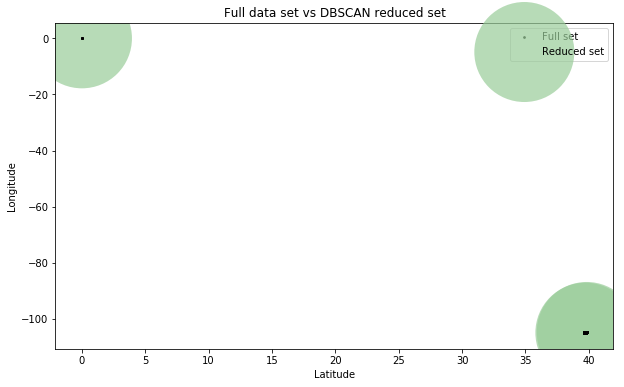

In [25]:
# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['GEO_LAT'], rs['GEO_LON'], c='#99cc99', edgecolor='None', alpha=0.7, s=10000)
df_scatter = ax.scatter(df1['GEO_LAT'], df1['GEO_LON'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

In [21]:
df1.describe()

,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID
count,12876.000000,12876.000000,12876.000000,12876.000000
mean,-104.912520,39.717576,3.672802,385.900746
std,2.069403,0.784019,1.784257,180.966852
min,-105.109336,0.000001,1.000000,111.000000
25%,-105.004613,39.703757,2.000000,222.000000
50%,-104.977538,39.739881,3.000000,324.000000
75%,-104.910224,39.758633,5.000000,523.000000
max,-0.000002,39.874789,7.000000,759.000000
